Task 1: Loading Data...
Extracting LDA Features...
LDA Feature Shape: (1312, 20)
Training Random Forest...
Random Forest (LDA) 10-Fold CV Accuracy: 0.4024

--- Random Forest Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.36      0.41      0.39        68
Frontotemporal Dementia       0.57      0.51      0.54        59
     Lewy Body Dementia       0.52      0.44      0.47        64
    Parkinson's Disease       0.36      0.31      0.33        68
      Vascular Dementia       0.50      0.61      0.55        70

               accuracy                           0.46       329
              macro avg       0.46      0.46      0.46       329
           weighted avg       0.46      0.46      0.45       329



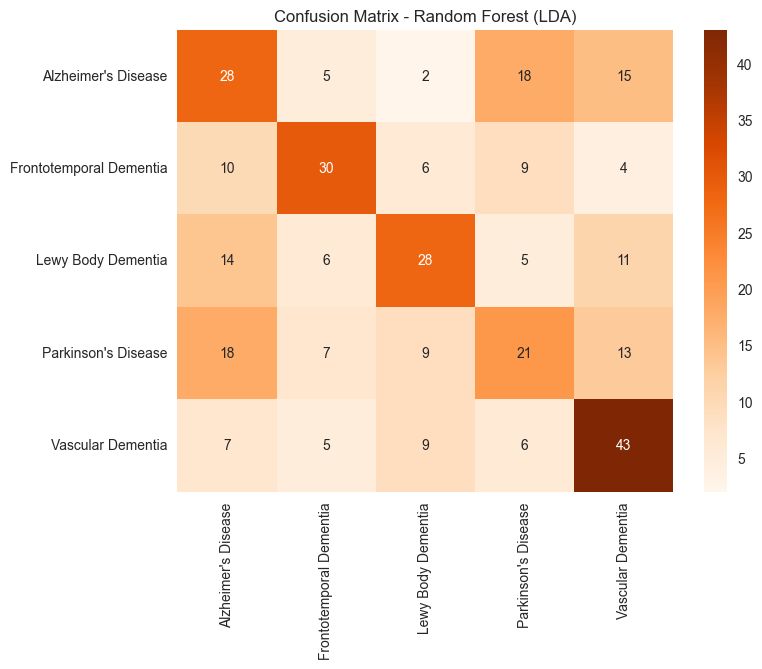

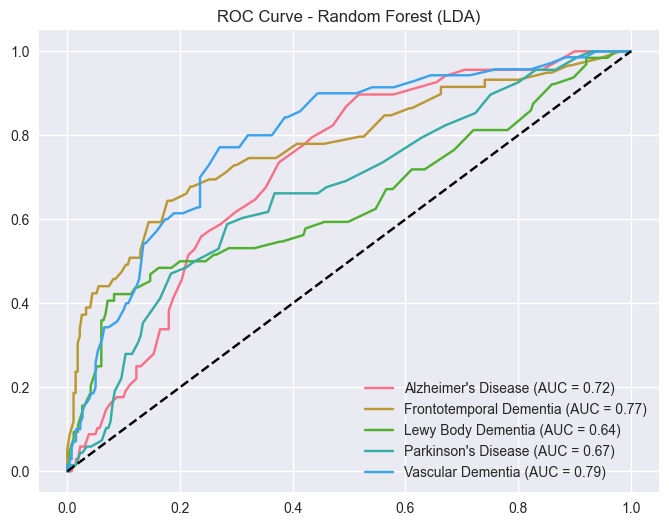


--- LDA Topics Interpretation ---
Topic 0: sleep, year, woman, age, regression, model, baseline, associated, mean, association
Topic 1: disease, patient, body, brain, motor, clinical, symptom, study, treatment, neurodegenerative
Topic 2: blood, brain, barrier, bbb, contrast, value, disruption, agent, correlation, time
Topic 3: inf, ci, mg, year, confidence, increase, decrease, hr, interval, associated
Topic 4: cortex, frontal, region, cortical, binding, patient, right, gyrus, temporal, uptake


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. 数据准备
# ==========================================
print("Task 1: Loading Data...")
df = pd.read_csv('cleaned_data.csv')
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)

# ==========================================
# 2. 特征工程: LDA
# ==========================================
print("Extracting LDA Features...")
# 步骤 A: 向量化 (CountVectorizer)
# LDA 需要词频 (Count) 而不是 TF-IDF
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(X_train_raw)
tf_test = tf_vectorizer.transform(X_test_raw)

# 步骤 B: LDA 模型训练
# 假设提取 20 个主题
lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', random_state=42, n_jobs=-1)
X_train_lda = lda.fit_transform(tf_train)
X_test_lda = lda.transform(tf_test)

print(f"LDA Feature Shape: {X_train_lda.shape}")

# ==========================================
# 3. 模型训练: Random Forest
# ==========================================
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 10折交叉验证
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_lda, y_train, cv=cv, scoring='accuracy')

print(f"Random Forest (LDA) 10-Fold CV Accuracy: {cv_scores.mean():.4f}")

# 全量训练
rf_model.fit(X_train_lda, y_train)

# ==========================================
# 4. 评估与可视化
# ==========================================
y_pred = rf_model.predict(X_test_lda)
y_prob = rf_model.predict_proba(X_test_lda)

print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))

# 混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Random Forest (LDA)')
plt.show()

# ROC 曲线
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
classes = lb.classes_

plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Random Forest (LDA)')
plt.legend()
plt.show()

# [可选] 打印 LDA 主题词
print("\n--- LDA Topics Interpretation ---")
feature_names = tf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_[:5]):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")